Demand Forecasting of Time Windows with a Large Number of Simultaneous Players

Data Science 100 - Final Project

Giles Lo

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)

library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 6)

set.seed(2025) # DO NOT REMOVE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Question: What time windows are most likely to have a large number of simultaneous players?

Reading "sessions.csv" Data Set

In [2]:
# read file

sessions <- read_csv("data/sessions.csv")

sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail                                                     
1    bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2    36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3    f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮    ⋮                                                               
1533 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1534 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1535 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
     start_time       end_time         original_start_time original_end_time
1    30/06/2024 18:12 30/06/2024 18:24 1.71977e+12         1.71977e+12      
2    17/06/2024 23:33 17/06/2024 23:46 1.71867e+12         1.71867e+12      
3    25/07/2024 17:34 25/07/2024 17:57 1.72193e+12         1.72193e+12      
⋮    ⋮                ⋮                ⋮                   ⋮                
1533 28/07/2024 15:36 28/07/2024 15:57 1.72218e+12         1.72218e+12      
1534 25/07/2024 06:15 25/07/2024 06:22 1.72189e+12         1.72189e+12      
1535 20/05/2024 02:26 20/05/2024 02:45 1.71617e+12         1.71617e+12

Exploring and Wrangling the Data

First, lets remove all the rows containing "NA" from the data.

In [3]:
# clean "sessions" data set

sessions_clean <- sessions |>
    select(start_time, end_time) |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ") |>
    filter(!is.na(start_date), !is.na(end_date), !is.na(start_time), !is.na(end_time))

sessions_clean

start_date start_time end_date   end_time
1    30/06/2024 18:12      30/06/2024 18:24   
2    17/06/2024 23:33      17/06/2024 23:46   
3    25/07/2024 17:34      25/07/2024 17:57   
⋮    ⋮          ⋮          ⋮          ⋮       
1531 28/07/2024 15:36      28/07/2024 15:57   
1532 25/07/2024 06:15      25/07/2024 06:22   
1533 20/05/2024 02:26      20/05/2024 02:45

Let's draw a single sample of size 50 from the population using bootstraping and visualize it as a plot.

In [4]:
# bootstrap sample of size 50

boot_sessions_50 <- sessions_clean |>
    rep_sample_n(size = 50, replace = TRUE, reps = 1)

head(boot_sessions_50)

replicate start_date start_time end_date   end_time
1 1         14/08/2024 07:07      14/08/2024 08:49   
2 1         03/08/2024 21:36      04/08/2024 01:51   
3 1         04/08/2024 14:43      04/08/2024 15:13   
4 1         15/06/2024 05:57      15/06/2024 06:23   
5 1         28/06/2024 02:50      28/06/2024 02:55   
6 1         28/06/2024 03:04      28/06/2024 03:10

Now let's count the total number of player sessions per month

In [5]:
# count player sessions per month

sessions_month_50 <- boot_sessions_50 |>
    mutate(start_date = as.Date(start_date, format = "%d/%m/%Y"), end_date = as.Date(end_date, format = "%d/%m/%Y")) |>
    mutate(date = map2(start_date, end_date, ~seq(.x, .y, by = "day"))) |>
    unnest(date) |>
    mutate(month = format(date, "%m")) |>
    count(month) |>
    rename(count = n)

sessions_month_50

replicate month count
1 1         04     3   
2 1         05     9   
3 1         06    20   
4 1         07    14   
5 1         08     7   
6 1         09     1

We now visualize the number of player sessions per month

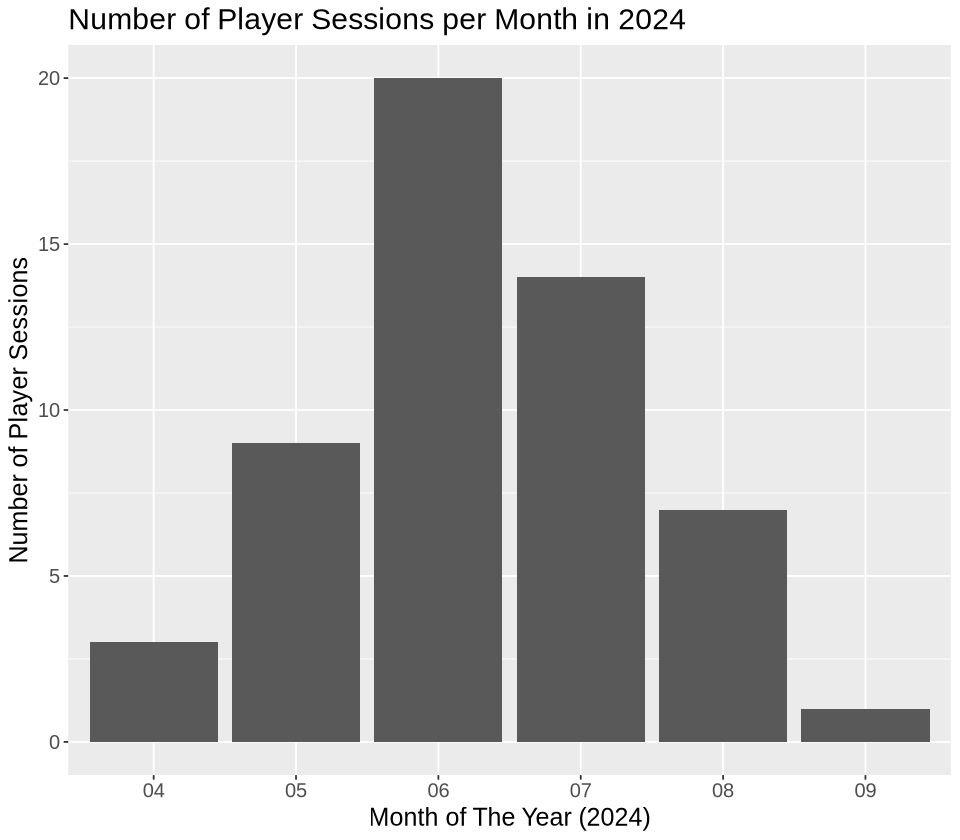

In [6]:
# visualize player sessions per month

options(repr.plot.width = 8, repr.plot.height = 7)

sessions_plot_50 <- sessions_month_50 |>
    ggplot(aes(x = month, y = count)) + 
    geom_col() +
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024") +
    theme(text = element_text(size = 15))

sessions_plot_50

The month of May appears to have the most number of player sesions, what about the for time/hour of day?

In [7]:
# count player sessions for each hour of the day

sessions_time_50 <- boot_sessions_50 |>
    mutate(start_datetime = as.POSIXct(paste(start_date, start_time), format = "%d/%m/%Y %H:%M"), 
           end_datetime = as.POSIXct(paste(end_date, end_time), format = "%d/%m/%Y %H:%M")) |>
    mutate(datetime = map2(start_datetime, end_datetime, ~seq(.x, .y, by = "hour"))) |>
    unnest(datetime) |>
    mutate(month = format(datetime, "%m"), 
           time = format(datetime, "%H:00")) |>
    count(month, time, name = "count")

sessions_time_50

sessions_time_max_50 <- sessions_time_50 |>
    group_by(time) |>
    summarize(count = round(mean(count))) |>
    arrange(desc(count)) |>
    slice(1) |>
    pull(time)

sessions_time_max_50

replicate month time  count
1  1         04    04:00 2    
2  1         04    05:00 1    
3  1         04    09:00 1    
⋮  ⋮         ⋮     ⋮     ⋮    
44 1         08    22:00 1    
45 1         08    23:00 1    
46 1         09    21:00 1

[1] "03:00"

It appears that the time window of 03:00 - 04:00 or 3:00 - 4:00 AM has the most number of concurrent players. Let's visualize this.

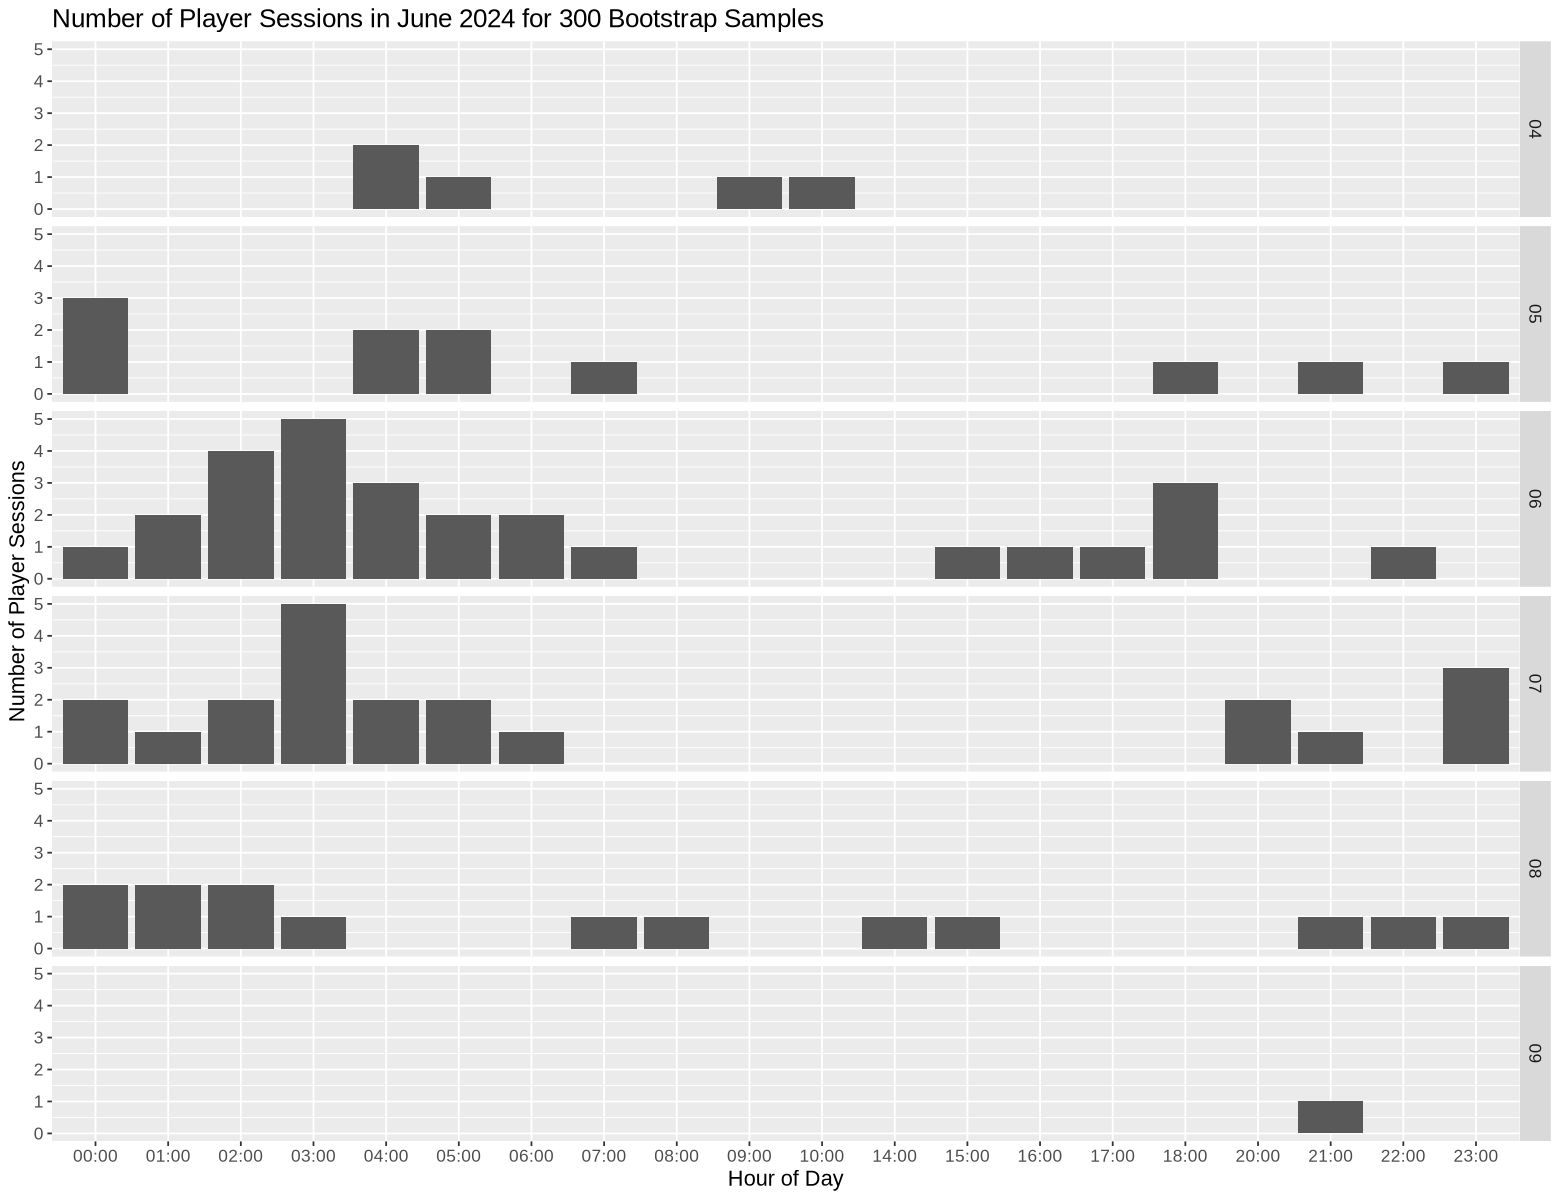

In [14]:
# visualize time window with the most number of concurrent players

options(repr.plot.width = 13, repr.plot.height = 10)

sessions_time_plot_50 <- sessions_time_50 |>
    ggplot(aes(x = time, y = count)) + 
    geom_col() + 
    facet_grid(rows = vars(month)) +
    labs(x = "Hour of Day",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions in June 2024 for 300 Bootstrap Samples",
         fill = "Repicate") +
    theme(text = element_text(size = 13))

sessions_time_plot_50

In the time window from approximately 23:00 - 07:00 or 11:00 PM - 7:00 AM, we have the most number of concurrent players.

Bootstraping Data

Now let's see what the time window for the most number of concurrents players are for a bootstrap sample of size 100 and 300 replicates.

In [9]:
# count player sessions per month

boot_sessions <- sessions_clean |>
    rep_sample_n(size = 100, replace = TRUE, reps = 300)

sessions_month <- boot_sessions |>
    mutate(start_date = as.Date(start_date, format = "%d/%m/%Y"), end_date = as.Date(end_date, format = "%d/%m/%Y")) |>
    mutate(date = map2(start_date, end_date, ~seq(.x, .y, by = "day"))) |>
    unnest(date) |>
    mutate(month = format(date, "%m")) |>
    count(month) |>
    rename(count = n)

sessions_month

sessions_month_average <- sessions_month |>
    group_by(month) |>
    summarize(count = round(mean(count)))

sessions_month_average

sessions_month_max <- sessions_month_average|>
    arrange(count) |>
    slice(1) |>
    pull()

sessions_month_max

replicate month count
1    1         04     9   
2    1         05    25   
3    1         06    28   
⋮    ⋮         ⋮     ⋮    
1798 300       07    30   
1799 300       08    13   
1800 300       09    10

month count
1 04    10   
2 05    24   
3 06    30   
4 07    20   
5 08    16   
6 09     6

[1] 6

We find that the month with the most number of current players is in June rather than May! Let's visualize this.

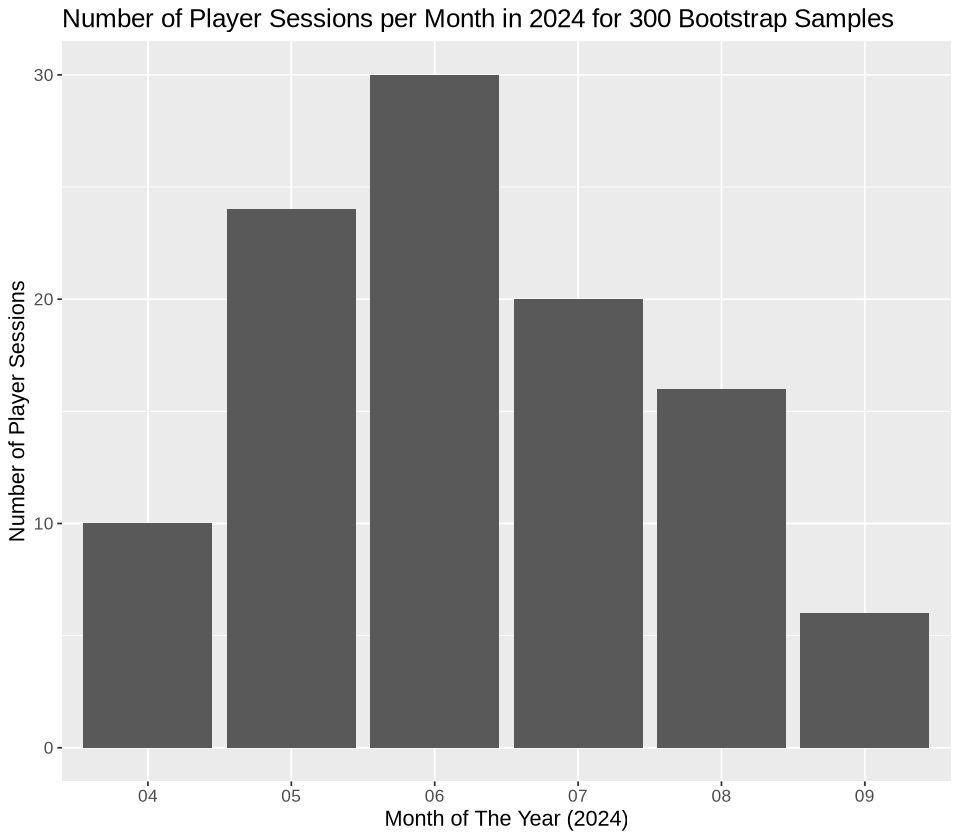

In [10]:
# visualize player sessions per month

options(repr.plot.width = 8, repr.plot.height = 7)

sessions_plot <- sessions_month_average |>
    ggplot(aes(x = month, y = count)) + 
    geom_col() + 
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024 for 300 Bootstrap Samples",
         fill = "Repicate") +
    theme(text = element_text(size = 13))

sessions_plot

We also see that May has a relatively large number of player sessions, as such we should increase the number of licenses on hand during May and June to sufficiently accommodate all parallel players with high probability. We now turn our attention to the time window.

In [11]:
# count player sessions for each hour of the day

sessions_time <- boot_sessions |>
    mutate(start_datetime = as.POSIXct(paste(start_date, start_time), format = "%d/%m/%Y %H:%M"), 
           end_datetime = as.POSIXct(paste(end_date, end_time), format = "%d/%m/%Y %H:%M")) |>
    mutate(datetime = map2(start_datetime, end_datetime, ~seq(.x, .y, by = "hour"))) |>
    unnest(datetime) |>
    mutate(month = format(datetime, "%m"), 
           time = format(datetime, "%H:00")) |>
    count(month, time, name = "count")

sessions_time

sessions_time_average <- sessions_time |>
    group_by(month, time) |>
    summarize(count = round(mean(count)))

sessions_time_average

sessions_time_max <- sessions_time |>
    group_by(time) |>
    summarize(count = round(mean(count))) |>
    arrange(desc(count)) |>
    slice(1) |>
    pull(time)

sessions_time_max

replicate month time  count
1     1         04    05:00 1    
2     1         04    06:00 1    
3     1         04    09:00 1    
⋮     ⋮         ⋮     ⋮     ⋮    
21446 300       09    15:00 1    
21447 300       09    22:00 2    
21448 300       09    23:00 4

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


month time  count
1   04    00:00 1    
2   04    01:00 1    
3   04    02:00 1    
⋮   ⋮     ⋮     ⋮    
127 09    21:00 1    
128 09    22:00 1    
129 09    23:00 1

[1] "00:00"

We observe that the time window of 00:00 - 01:00 or 12:00 - 10:00 AM has the most number of concurrent players. Let's visualize this.

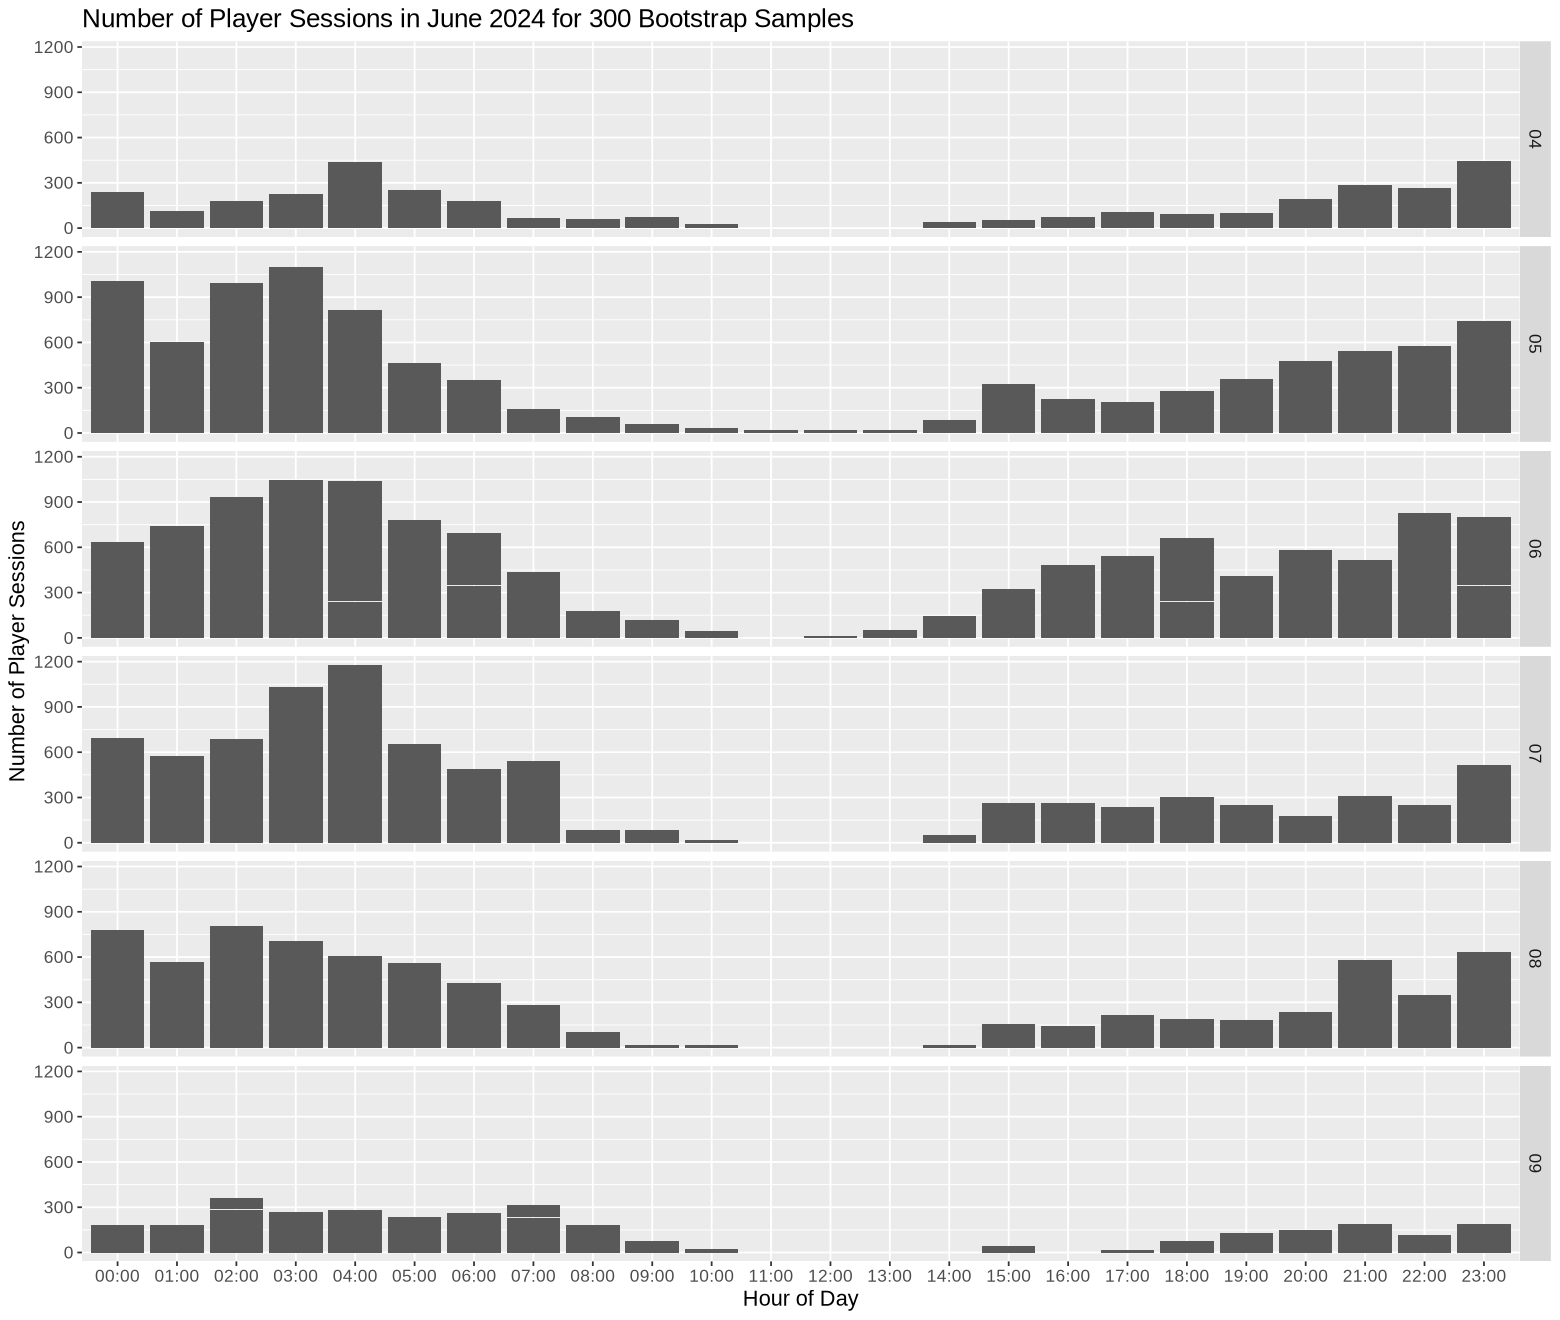

In [15]:
# visualize time window with the most number of concurrent players

options(repr.plot.width = 13, repr.plot.height = 11)

sessions_time_plot <- sessions_time |>
    ggplot(aes(x = time, y = count)) + 
    geom_col() + 
    facet_grid(rows = vars(month)) +
    labs(x = "Hour of Day",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions in June 2024 for 300 Bootstrap Samples",
         fill = "Repicate") +
    theme(text = element_text(size = 13))

sessions_time_plot

We observe that in the time window of 21:00 - 07:00 or 9:00 PM - 7:00 AM, there is consistently a large number of concurrent players. Furthermore, there is a decent number of concurrent players from 15:00 - 21:00 or 3:00 - 9:00 PM. As such, we should increase the number of licenses throughout the night beginning at 3:00 PM, peaking at approximately 2:00 - 5:00 AM, before decrease them until 7:00 AM.

In conclusion, we should increase the number of licenses during in May and June from approximately 3:00 PM - 7:00 AM during which there are the greatest number of concurrent players so that we can sufficiently accommodate all parallel players with high probability.